# Model structure
- (DTW - Dynamic Time Warping)
- JS Divergence (measuring similarity between two probability distributions)
- ReLU activation except the last layer
- L-th Layer adopts linear activation followed by 1x1 Conv Layer
- DTr-CNN
    - Input: Sets of potential source time series 
    - Outputs: Parameters in trained network architecture
    - Phase 1: 
        - compute similarities between target series and time series 
        - source domain, set with smalled dissimilarity
        - => don't need that, source and target domain are known
    - Phase 2:
        - train model on source dataset, extract features and parameters
        - Initialize attributes of target network with parameters obtained from before

# Changes
- 1D to M-D Layers => 3D Output?
- create 1D Bottleneck
- do Phase 1 at the end to check data between machines


---
# Data input
- several 1D sequences => predict x+1 (needs to be changed to predict current in 3D?)

---
# Data output
- 3D Output for the current of every axis

--- 
# Ideas:
- Material information not needed becauses speed depends on move and material
- I seperate the datasets in segments of size 500 steps => what happens if you seperate one move?
- 1 Dimension for config data

---
# Approach:
- first implement basic structure with short random time series
- eval structure
- scale the model to the real data up
- train the model
- first checkup/eval before big training

--- 
# Notes:
- began with time series model for some random data to get the model structure
- changed to time series dimension and scales model up(first 1D) =>

In [1]:
#Imports
#
#

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Data Import
#
#



# Example small dataset with 5 timesteps and 2-dimensional coordinates
X_small = np.random.rand(10, 5, 2)  # 10 samples, 5 timesteps, 2 features (coordinates)
y_small = np.random.rand(10, 5, 1)  # 10 samples, 5 timesteps, 1 output (power consumption)

# Convert to PyTorch tensors
X_small = torch.tensor(X_small, dtype=torch.float32)
y_small = torch.tensor(y_small, dtype=torch.float32)

df = pd.read_csv('../dataset/Data/DMG_CMX_600V/AL2007_Bauteil_1/CMX_Alu_Tr_Mat_1_alldata_allforces_MRR_allcurrent.csv')

print("Data imported")

Data imported


In [3]:
#Data preprocessing
#
#
# seperate dataset into segments with 500 steps each (1 sec.)
size_segment = 500

#def split_dataframe(df, segment_length):
#    num_segments = len(df) // segment_length
#    segments = []
#    for i in range(num_segments):
#        segment = df.iloc[:i * segment_length,:].values
#        segments.append(segment)
#    # Handling the remaining part if the length of the DataFrame is not a multiple of segment_length
#    if len(df) % segment_length != 0:
#        remaining_segment = df.iloc[num_segments * segment_length:].values
#        segments.append(remaining_segment)
#    return np.array(segments)

#segments = split_dataframe(df, size_segment)

segments = [df[i:i+size_segment] for i in range(0,len(df),size_segment)]

# The shape of segments array will be (number_of_segments, size_segment, 34) if there are no remaining segments
# If there are remaining segments, the last segment will have a different number of rows
print("Amounts of segments list:", len(segments))
print("Size of one list element: ", segments[0].shape)



# Define indices for splitting the data
train_indices = range(0, 300)
test_indices = range(300, 330)
validation_indices = range(330, 347)

# Create separate lists for training, testing, and validation segments
segments_training = [segments[i] for i in train_indices]
segments_test = [segments[i] for i in test_indices]
segments_validation = [segments[i] for i in validation_indices]

# Print the number of segments in each set
print(f"Number of training segments: {len(segments_training)}")
print(f"Number of testing segments: {len(segments_test)}")
print(f"Number of validation segments: {len(segments_validation)}")


print("Preprocessing Done")

Amounts of segments list: 347
Size of one list element:  (500, 34)
Number of training segments: 300
Number of testing segments: 30
Number of validation segments: 17
Preprocessing Done


In [6]:
#Functions
#
#
def extractPos(df, pos):
    #print("Segments splitted to one Position")
    return df[pos]


print("Functions implemented")
#print(extractPos(segments[0]))

Functions implemented


In [6]:
#Model class
#
#


input_shape = (1,500)  # 500 timesteps, 1 feature (only y position)


class Base_Model(nn.Module):

    def __init__(self, input_shape):
        super(Base_Model, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_shape[0], out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        
        self.conv7 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        
        self.conv8 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()
        
        # Calculate the flattened size
        self.flatten_size = 256 * (input_shape[1])  # 256 channels * 500 timesteps
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.fc_relu1 = nn.ReLU()

        self.fc2 = nn.Linear(1024, input_shape[0] * input_shape[1])




    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        #print(f'After conv1: {x.shape}')
        
        x = self.conv2(x)
        x = self.relu2(x)
        #print(f'After conv2: {x.shape}')
        
        x = self.conv3(x)
        x = self.relu3(x)
        #print(f'After conv3: {x.shape}')
        
        x = self.conv4(x)
        x = self.relu4(x)
        #print(f'After conv4: {x.shape}')

        x = self.conv5(x)
        x = self.relu5(x)
        #print(f'After conv5: {x.shape}')
        
        x = self.conv6(x)
        x = self.relu6(x)
        #print(f'After conv6: {x.shape}')

        x = self.conv7(x)
        x = self.relu7(x)
        #print(f'After conv7: {x.shape}')

        x = self.conv8(x)
        x = self.relu8(x)
        #print(f'After conv8: {x.shape}')

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print(f'After flattening: {x.shape}')

        x = self.fc1(x)
        x = self.fc_relu1(x)

        x = self.fc2(x)
        x = x.view(x.size(0), input_shape[0], input_shape[1])
        return x

In [11]:
#Model implementation
#
#


# Define input shape
model = Base_Model(input_shape)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Dummy input for testing
dummy_input = torch.randn(1, 1, 500)
dummy_output = model(dummy_input)
print(f'Dummy output shape: {dummy_output.shape}')

summary(model, (1,500))

Dummy output shape: torch.Size([1, 1, 500])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 500]             256
              ReLU-2              [-1, 64, 500]               0
            Conv1d-3             [-1, 128, 500]          24,704
              ReLU-4             [-1, 128, 500]               0
            Conv1d-5             [-1, 128, 500]          49,280
              ReLU-6             [-1, 128, 500]               0
            Conv1d-7             [-1, 256, 500]          98,560
              ReLU-8             [-1, 256, 500]               0
            Conv1d-9             [-1, 256, 500]         196,864
             ReLU-10             [-1, 256, 500]               0
           Conv1d-11             [-1, 256, 500]         196,864
             ReLU-12             [-1, 256, 500]               0
           Conv1d-13             [-1, 256, 500]         196

In [7]:
#Training
#
#



# Training loop
num_epochs = 10000  # Number of epochs to train the model
losses = []
num_segments_per_epoch = 1


for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    epoch_loss = 0  # To accumulate loss over the segments in one epoch
    
    # Randomly select 10 segments from segments_training
    selected_indices = torch.randperm(len(segments_training))[:num_segments_per_epoch]
    selected_segments = [segments_training[i] for i in selected_indices]


    for segment in selected_segments:
        # Access the segment for the current epoch
        # Use modulo in case num_epochs > len(segments)
        #segments_training = segments_training[epoch % len(segments)]  
        # Extract the position data
        # Extract the position data
        pos_y = torch.tensor(extractPos(segment, 'pos_y').values, dtype=torch.float32)
        curr_y = torch.tensor(extractPos(segment, 'curr_y').values, dtype=torch.float32)
        
        # Ensure the tensors have the correct shape for your model
        # Assuming your model expects inputs of shape (batch_size, features)
        pos_y = pos_y.unsqueeze(0).unsqueeze(0)  # Add batch dimension
        curr_y = curr_y.unsqueeze(0).unsqueeze(0)  # Add batch dimension

        #print(f"Epoch [{epoch+1}/{num_epochs}], pos_y shape: {pos_y.shape}, curr_y shape: {curr_y.shape}")
        
        # Forward pass
        #outputs = model(X_small.permute(0, 2, 1))  # Permute to match Conv1d input shape (batch_size, features, timesteps)
        outputs = model(pos_y)

        # The output shape should be (batch_size, timesteps, 1) after permuting back
        #loss = criterion(outputs.permute(0, 2, 1), y_small)  # Calculate loss
        loss = criterion(outputs, curr_y)

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Store the loss value for plotting later
        #losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradient buffers
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
    
    # Average loss for the epoch
    average_epoch_loss = epoch_loss / num_segments_per_epoch
    losses.append(average_epoch_loss)
    
    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_epoch_loss:.4f}')

    # Print loss for each epoch
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10000], Average Loss: 21369.0781
Epoch [2/10000], Average Loss: 13762757.0000
Epoch [3/10000], Average Loss: 1086309.1250
Epoch [4/10000], Average Loss: 213886.6875
Epoch [5/10000], Average Loss: 19228.4824
Epoch [6/10000], Average Loss: 26304.7812
Epoch [7/10000], Average Loss: 3833.2942
Epoch [8/10000], Average Loss: 4582.3784
Epoch [9/10000], Average Loss: 3733.6340
Epoch [10/10000], Average Loss: 1304.1355
Epoch [11/10000], Average Loss: 3541.3525
Epoch [12/10000], Average Loss: 721.0344
Epoch [13/10000], Average Loss: 125.6663
Epoch [14/10000], Average Loss: 2514.2246
Epoch [15/10000], Average Loss: 3147.3193
Epoch [16/10000], Average Loss: 1733.4994
Epoch [17/10000], Average Loss: 3.6337
Epoch [18/10000], Average Loss: 3.3551
Epoch [19/10000], Average Loss: 49.2587
Epoch [20/10000], Average Loss: 0.1460
Epoch [21/10000], Average Loss: 3527.0654
Epoch [22/10000], Average Loss: 2663.1565
Epoch [23/10000], Average Loss: 2.2096
Epoch [24/10000], Average Loss: 0.4339
Epoch [2

In [8]:
# Save the model state dictionary
torch.save(model.state_dict(), 'model.pth')

# Assuming the same model architecture
#model = Base_Model(input_shape)
#model.load_state_dict(torch.load('model.pth'))
#model.eval()  # Set the model to evaluation mode

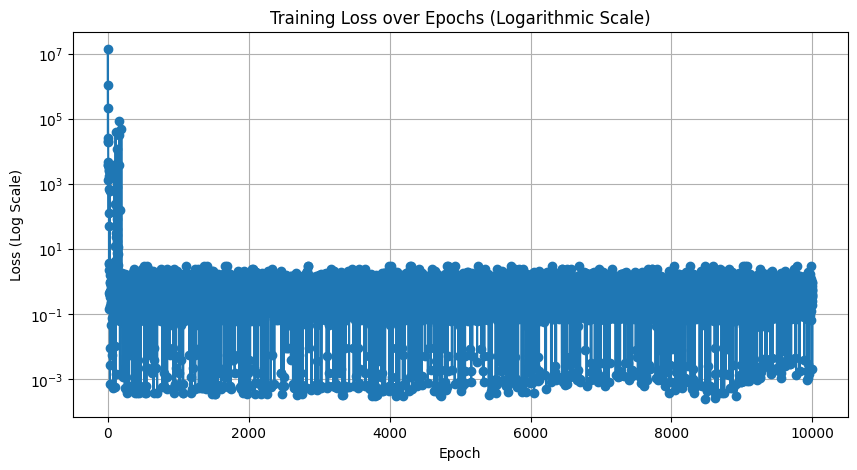

In [19]:
#Evaluation
#
#



# Plot the loss over epochs
"""plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()"""

#Plot the loss over epochs (logarithmic) => for high value range
plt.figure(figsize=(10, 5))
plt.semilogy(range(1, num_epochs+1), losses, marker='o')
plt.title('Training Loss over Epochs (Logarithmic Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.grid(True)
plt.show()

In [31]:
#Testing
#
#



model.eval()  # Set model to evaluation mode
test_losses = []  # List to store test loss values
predicted_values = []
actual_values = []

with torch.no_grad():  # Disable gradient calculation
    for segment in segments_test:
        # Extract the position data
        pos_y = torch.tensor(extractPos(segment, 'pos_y').values, dtype=torch.float32)
        curr_y = torch.tensor(extractPos(segment, 'curr_y').values, dtype=torch.float32)
        
        # Ensure the tensors have the correct shape for your model
        pos_y = pos_y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        curr_y = curr_y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        
        # Forward pass
        outputs = model(pos_y)
        
        # Calculate loss
        loss = criterion(outputs, curr_y)
        test_losses.append(loss.item())
        
        # Collect predicted and actual values for plotting
        predicted_values.append(outputs.squeeze().numpy())
        actual_values.append(curr_y.squeeze().numpy())

# Calculate average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')


Average Test Loss: 0.4271


In [32]:
print(predicted_values)

[array([-0.01090006, -0.02099235, -0.02417941, -0.02423406, -0.02597906,
       -0.02265049, -0.02842241, -0.02377356, -0.03810048, -0.03236109,
       -0.05081169, -0.05432475, -0.05656858, -0.05968524, -0.05717597,
       -0.0530671 , -0.04973446, -0.03164703, -0.05531155, -0.04661355,
       -0.0496921 , -0.04989772, -0.04817498, -0.04618671, -0.05156487,
       -0.0503112 , -0.05457426, -0.0598421 , -0.05885843, -0.06290111,
       -0.06648741, -0.06247919, -0.07990307, -0.07370387, -0.06587347,
       -0.0659065 , -0.05679529, -0.06135992, -0.05349844, -0.04995556,
       -0.05175394, -0.04886276, -0.03943055, -0.03950086, -0.03210535,
       -0.01842622, -0.02329085, -0.01827115, -0.01064218, -0.00755111,
       -0.00792591, -0.00971836, -0.01100082, -0.01816483, -0.01841862,
       -0.02178898, -0.01349916, -0.02791221, -0.02679197, -0.01993921,
       -0.0203735 , -0.02096322, -0.02239426, -0.02234423, -0.02356171,
       -0.02417337, -0.02395434, -0.02887705, -0.0358471 , -0.0

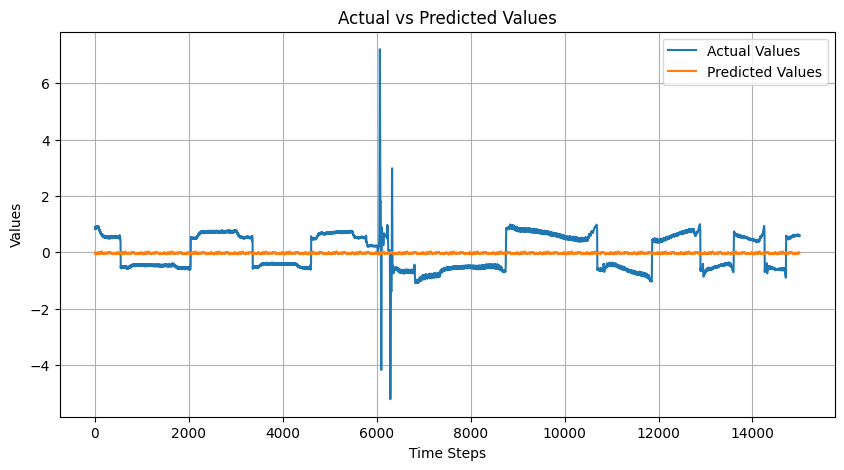

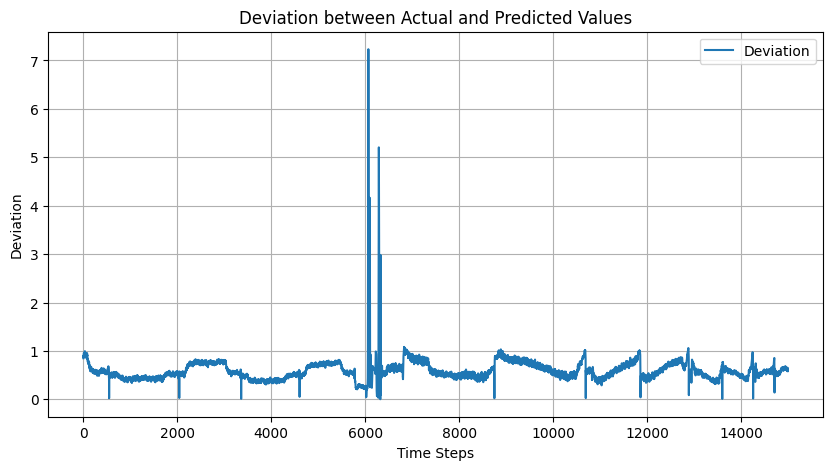

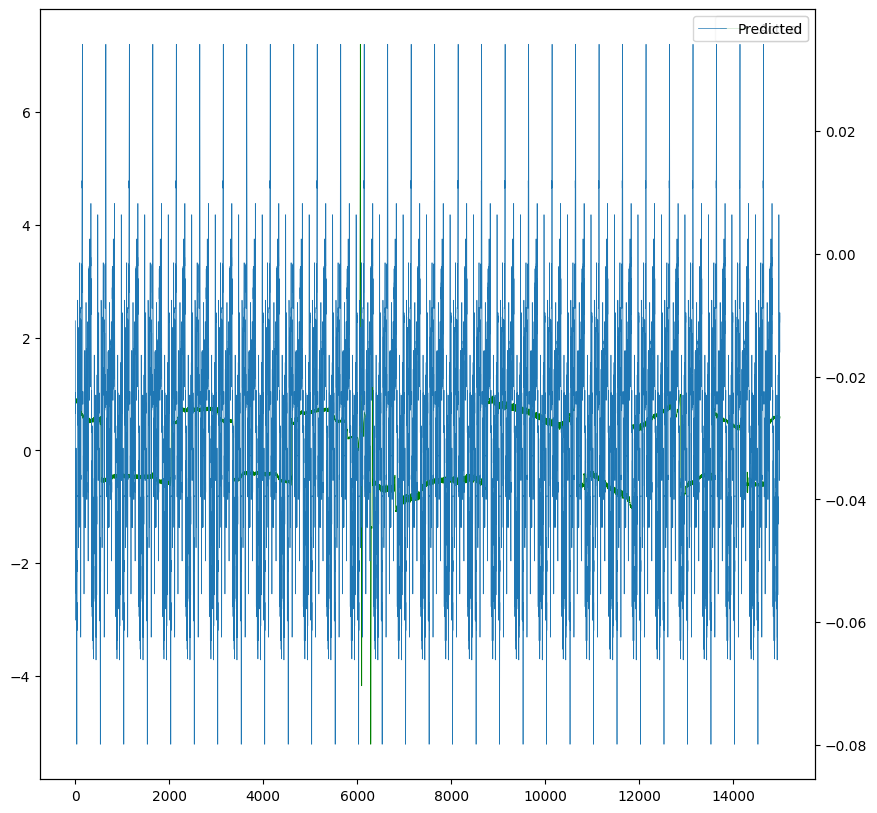

In [33]:
#Testing results
#
#



# Convert lists to numpy arrays for easier manipulation
predicted_values = np.concatenate(predicted_values)
actual_values = np.concatenate(actual_values)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actual_values, label='Actual Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot deviation
deviation = np.abs(actual_values - predicted_values)
plt.figure(figsize=(10, 5))
plt.plot(deviation, label='Deviation')
plt.title('Deviation between Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Deviation')
plt.legend()
plt.grid(True)
plt.show()


figure, ax1 = plt.subplots()
# Plot the cumulative sums
ax1.plot(actual_values, linewidth=0.5, zorder=1, label="Actual", color = "green")
# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(predicted_values, linewidth=0.5, zorder=1, label="Predicted")
# Add the legend
ax1.legend()
ax2.legend()
# Set the figure size
figure.set_figheight(10)
figure.set_figwidth(10)
# Show the plot
plt.show()

In [9]:
modelSpindel = Base_Model(input_shape)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(modelSpindel, (1,500))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 500]             256
              ReLU-2              [-1, 64, 500]               0
            Conv1d-3             [-1, 128, 500]          24,704
              ReLU-4             [-1, 128, 500]               0
            Conv1d-5             [-1, 128, 500]          49,280
              ReLU-6             [-1, 128, 500]               0
            Conv1d-7             [-1, 256, 500]          98,560
              ReLU-8             [-1, 256, 500]               0
            Conv1d-9             [-1, 256, 500]         196,864
             ReLU-10             [-1, 256, 500]               0
           Conv1d-11             [-1, 256, 500]         196,864
             ReLU-12             [-1, 256, 500]               0
           Conv1d-13             [-1, 256, 500]         196,864
             ReLU-14             [-1, 2

Epoch [1/1000], Average Loss: 920778056.0268
Epoch [2/1000], Average Loss: 7483195.6674
Epoch [3/1000], Average Loss: 4.2583
Epoch [4/1000], Average Loss: 2.9981
Epoch [5/1000], Average Loss: 1.9343
Epoch [6/1000], Average Loss: 2.1730
Epoch [7/1000], Average Loss: 1.4787
Epoch [8/1000], Average Loss: 2.2223
Epoch [9/1000], Average Loss: 2.1114
Epoch [10/1000], Average Loss: 2.0562
Epoch [11/1000], Average Loss: 5674.8539
Epoch [12/1000], Average Loss: 1.6104
Epoch [13/1000], Average Loss: 3.7726
Epoch [14/1000], Average Loss: 9589.0427
Epoch [15/1000], Average Loss: 118.6905
Epoch [16/1000], Average Loss: 468.9512
Epoch [17/1000], Average Loss: 359451.2433
Epoch [18/1000], Average Loss: 1.1733
Epoch [19/1000], Average Loss: 2.2786
Epoch [20/1000], Average Loss: 4.3275
Epoch [21/1000], Average Loss: 2.9469
Epoch [22/1000], Average Loss: 1.5599
Epoch [23/1000], Average Loss: 1.7729
Epoch [24/1000], Average Loss: 2.4628
Epoch [25/1000], Average Loss: 2.1663
Epoch [26/1000], Average Loss:

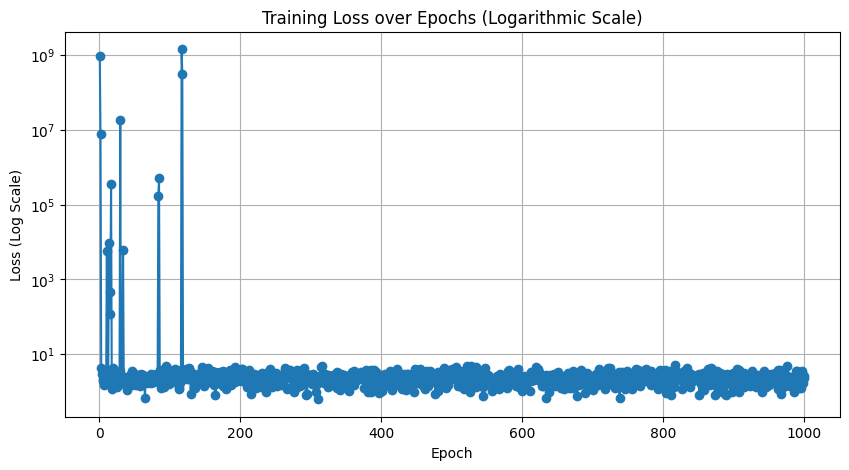

In [8]:
#Training
#
#



# Training loop
num_epochs = 1000  # Number of epochs to train the model
losses = []
num_segments_per_epoch = 10


for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    epoch_loss = 0  # To accumulate loss over the segments in one epoch
    
    # Randomly select 10 segments from segments_training
    selected_indices = torch.randperm(len(segments_training))[:num_segments_per_epoch]
    selected_segments = [segments_training[i] for i in selected_indices]


    for segment in selected_segments:
        # Access the segment for the current epoch
        # Use modulo in case num_epochs > len(segments)
        #segments_training = segments_training[epoch % len(segments)]  
        # Extract the position data
        # Extract the position data
        pos_y = torch.tensor(extractPos(segment, 'pos_sp').values, dtype=torch.float32)
        curr_y = torch.tensor(extractPos(segment, 'curr_sp').values, dtype=torch.float32)
        
        # Ensure the tensors have the correct shape for your model
        # Assuming your model expects inputs of shape (batch_size, features)
        pos_y = pos_y.unsqueeze(0).unsqueeze(0)  # Add batch dimension
        curr_y = curr_y.unsqueeze(0).unsqueeze(0)  # Add batch dimension

        #print(f"Epoch [{epoch+1}/{num_epochs}], pos_y shape: {pos_y.shape}, curr_y shape: {curr_y.shape}")
        
        # Forward pass
        #outputs = model(X_small.permute(0, 2, 1))  # Permute to match Conv1d input shape (batch_size, features, timesteps)
        outputs = model(pos_y)

        # The output shape should be (batch_size, timesteps, 1) after permuting back
        #loss = criterion(outputs.permute(0, 2, 1), y_small)  # Calculate loss
        loss = criterion(outputs, curr_y)

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Store the loss value for plotting later
        #losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradient buffers
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
    
    # Average loss for the epoch
    average_epoch_loss = epoch_loss / num_segments_per_epoch
    losses.append(average_epoch_loss)
    
    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_epoch_loss:.4f}')

    # Print loss for each epoch
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


#Plot the loss over epochs (logarithmic) => for high value range
plt.figure(figsize=(10, 5))
plt.semilogy(range(1, num_epochs+1), losses, marker='o')
plt.title('Training Loss over Epochs (Logarithmic Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.grid(True)
plt.show()

In [9]:
# Save the model state dictionary
torch.save(model.state_dict(), 'modelSpindel.pth')

In [7]:
model = Base_Model(input_shape)
model.load_state_dict(torch.load('model_trained/BaseModel_PosSpindel.pth'))

<All keys matched successfully>

Average Test Loss: 31006252.4000


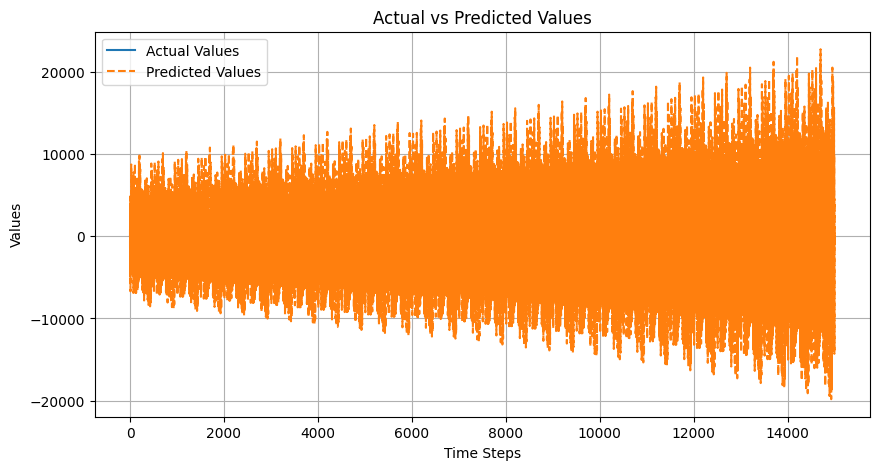

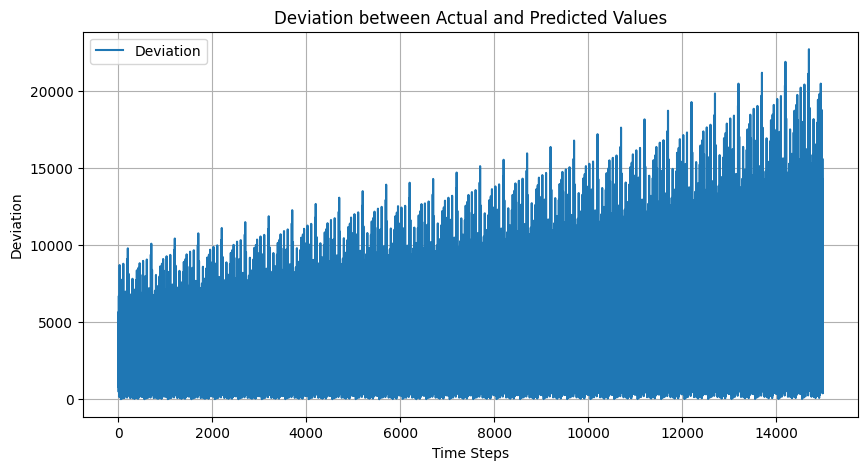

In [13]:
model.eval()  # Set model to evaluation mode
test_losses = []  # List to store test loss values
predicted_values = []
actual_values = []

with torch.no_grad():  # Disable gradient calculation
    for segment in segments_test:
        # Extract the position data
        pos_sp = torch.tensor(extractPos(segment, 'pos_sp').values, dtype=torch.float32)
        curr_sp = torch.tensor(extractPos(segment, 'curr_sp').values, dtype=torch.float32)
        
        # Ensure the tensors have the correct shape for your model
        pos_sp = pos_sp.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        curr_sp = curr_sp.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        
        # Forward pass
        outputs = model(pos_sp)
        
        # Calculate loss
        loss = criterion(outputs, curr_sp)
        test_losses.append(loss.item())
        
        # Collect predicted and actual values for plotting
        predicted_values.append(outputs.squeeze().numpy())
        actual_values.append(curr_sp.squeeze().numpy())

# Calculate average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')

# Convert lists to numpy arrays for easier manipulation
predicted_values = np.concatenate(predicted_values)
actual_values = np.concatenate(actual_values)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actual_values, label='Actual Values')
plt.plot(predicted_values, label='Predicted Values', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot deviation
deviation = np.abs(actual_values - predicted_values)
plt.figure(figsize=(10, 5))
plt.plot(deviation, label='Deviation')
plt.title('Deviation between Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Deviation')
plt.legend()
plt.grid(True)
plt.show()

Average Test Loss: 36353035.1363


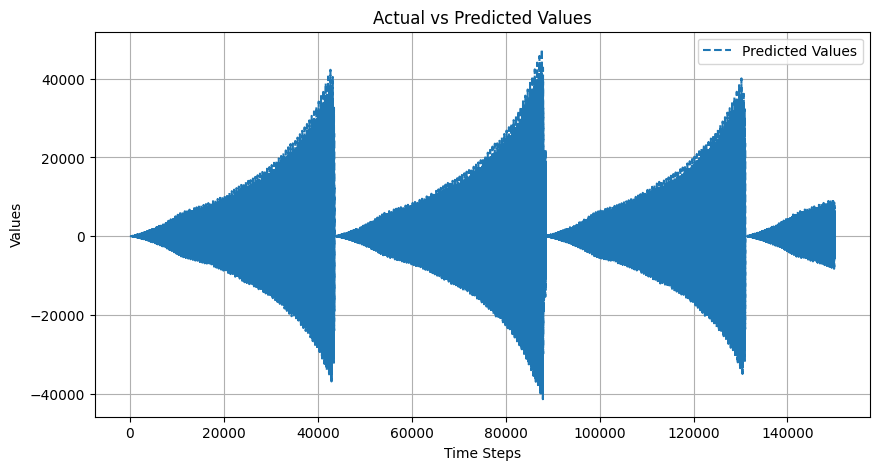

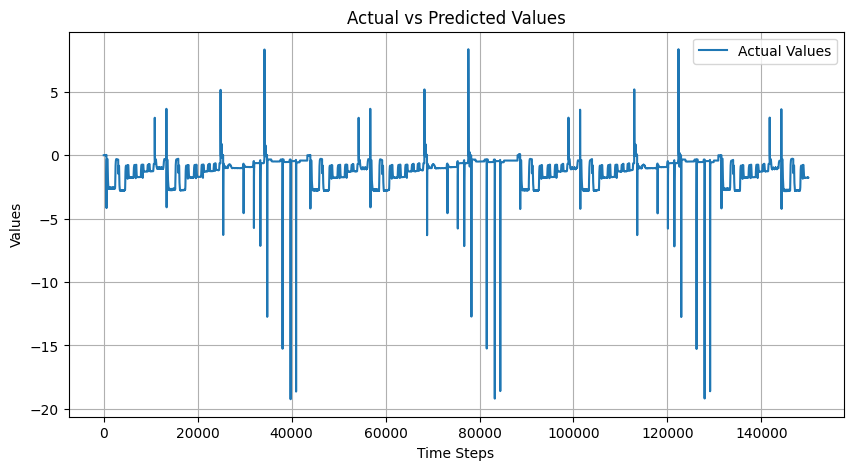

In [17]:
model.eval()  # Set model to evaluation mode
test_losses = []  # List to store test loss values
predicted_values = []
actual_values = []

with torch.no_grad():  # Disable gradient calculation
    for segment in segments_training:
        # Extract the position data
        pos_sp = torch.tensor(extractPos(segment, 'pos_sp').values, dtype=torch.float32)
        curr_sp = torch.tensor(extractPos(segment, 'curr_sp').values, dtype=torch.float32)
        
        # Ensure the tensors have the correct shape for your model
        pos_sp = pos_sp.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        curr_sp = curr_sp.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        
        # Forward pass
        outputs = model(pos_sp)
        
        # Calculate loss
        loss = criterion(outputs, curr_sp)
        test_losses.append(loss.item())
        
        # Collect predicted and actual values for plotting
        predicted_values.append(outputs.squeeze().numpy())
        actual_values.append(curr_sp.squeeze().numpy())

# Calculate average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')

# Convert lists to numpy arrays for easier manipulation
predicted_values = np.concatenate(predicted_values)
actual_values = np.concatenate(actual_values)


# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(predicted_values, label='Predicted Values', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actual_values, label='Actual Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
sum_pred = np.sum(predicted_values)
sum_actual = np.sum(actual_values)

print("predicted Value sum: ", sum_pred)
print("actual values sum: ", sum_actual)

predicted Value sum:  -3346915.8
actual values sum:  -174121.92
